In [1]:
import numpy as np
from scipy.constants import c, e, m_e

In [2]:
from fbpic.main import Simulation
from fbpic.lpa_utils.laser import add_laser_pulse
from fbpic.lpa_utils.laser.laser_profiles import GaussianLaser
from fbpic.openpmd_diag import FieldDiagnostic, ParticleDiagnostic, set_periodic_checkpoint, restart_from_checkpoint


CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.

Failed to detect UUID of GPU 0 (invalid UUID length: 19)


Laser Wakefield FBPIC Simulation script from https://fbpic.github.io/example_input/lwfa_script.html

# Parameters

In [3]:
use_cuda = True

In [4]:
# Order of the stencil for z derivatives in the Maxwell solver
# -1 advised for single-GPU/CPU
n_order = -1

# The simulation box
Nz = 800*3        # Number of gridpoints along z
zmax = 30.e-6    # Right end of the simulation box (meters)
zmin = -90.e-6 # -10.e-6   # Left end of the simulation box (meters)
Nr = 50*2          # Number of gridpoints along r
rmax = 2*20.e-6    # Length of the box along r (meters)
Nm = 2           # Number of modes used

In [5]:
# Timestep (seconds)
dt = (zmax-zmin)/Nz/c

In [6]:
# The particles
p_zmin = 30.e-6  # Position of the beginning of the plasma (meters)
p_zmax = 500.e-6 # Position of the end of the plasma (meters)
p_rmax = 2*18.e-6 #18.e-6  # Maximal radial position of the plasma (meters)
n_e = 4.e18*1.e6 # Density (electrons.meters^-3)
p_nz = 2         # Number of particles per cell along z
p_nr = 2         # Number of particles per cell along r
p_nt = 4         # Number of particles per cell along theta

In [21]:
# The particles
p_zmin = 0  # Position of the beginning of the plasma (meters)
p_zmax = 0 # Position of the end of the plasma (meters)
p_rmax = 0 #18.e-6  # Maximal radial position of the plasma (meters)
n_e = 0 # Density (electrons.meters^-3)
p_nz = 2         # Number of particles per cell along z
p_nr = 2         # Number of particles per cell along r
p_nt = 4         # Number of particles per cell along theta

In [7]:
# The laser
a0 = 4.*2          # Laser amplitude
w0 = 5.e-6       # Laser waist
tau = 16.e-15 # 50.e-15     # Laser duration
z0 = (zmax+zmin)/2 # 15.e-6      # Laser centroid

In [8]:
# The moving window
v_window = c

In [9]:
# The diagnostics and the checkpoints/restarts
diag_period = 50         # Period of the diagnostics in number of timesteps
save_checkpoints = False # Whether to write checkpoint files
checkpoint_period = 100  # Period for writing the checkpoints
use_restart = False      # Whether to restart from a previous checkpoint
track_electrons = False  # Whether to track and write particle ids

In [10]:
# The density profile
ramp_start = 30.e-6
ramp_length = 40.e-6

In [11]:
# Returns relative density at position z and r
def dens_func( z, r ):
    n = np.ones_like(z)
    # Make linear ramp
    n = np.where( z<ramp_start+ramp_length, (z-ramp_start)/ramp_length, n )
    # Supress density before the ramp
    n = np.where( z<ramp_start, 0., n )
    return n

In [12]:
# The interaction length of the simulation (meters)
L_interact = 50.e-6 / 5 #* 5

# Interaction time (seconds) (to calculate number of PIC iterations)
T_interact = ( L_interact + (zmax-zmin) ) / v_window

# Simulation

In [13]:
sim = Simulation( Nz, zmax, Nr, rmax, Nm, dt, zmin=zmin,
        n_order=n_order, use_cuda=use_cuda,
        boundaries={'z':'open', 'r':'reflective'})


FBPIC (0.25.0)

Running on GPU 



In [22]:
# Create Plasma Electrons
elec = sim.add_new_species( q=-e, m=m_e, n=n_e,
        dens_func=dens_func, p_zmin=p_zmin, p_zmax=p_zmax, p_rmax=p_rmax,
        p_nz=p_nz, p_nr=p_nr, p_nt=p_nt )

### Create Initial Fields

In [23]:
# Create a Gaussian laser profile
laser_profile = GaussianLaser(a0, w0, tau, z0)

# Add the laser to the fields of the simulation
add_laser_pulse( sim, laser_profile)

Initializing laser pulse on the mesh...
Done.



In [24]:
if use_restart is False:
    # Track electrons if required (species 0 correspond to the electrons)
    if track_electrons:
        elec.track( sim.comm )
else:
    # Load the fields and particles from the latest checkpoint file
    restart_from_checkpoint( sim )

In [25]:
# Configure the moving window
sim.set_moving_window( v=v_window )

In [26]:
# Add diagnostics
sim.diags = [ FieldDiagnostic( diag_period, sim.fld, comm=sim.comm ),
              ParticleDiagnostic( diag_period, {"electrons" : elec},
                select={"uz" : [1., None ]}, comm=sim.comm ) ]

In [27]:
# Add checkpoints
if save_checkpoints:
    set_periodic_checkpoint( sim, checkpoint_period )

In [28]:
# Number of iterations to perform
N_step = int(T_interact/sim.dt)

In [29]:
### Run the simulation
sim.step( N_step )
print('')

|███████████████████████████████████| 2600/2600, 0:00:00 left, 126 ms/steppK                                   | 12/2600, calc. ETA..., 108 ms/step             | 1685/2600, 0:02:24 left, 140 ms/step
Total time taken (with compilation): 0:12:09
Average time per iteration (with compilation): 280 ms




# Visualization

From https://fbpic.github.io/advanced/3d_visualization.html

In [22]:
from openpmd_viewer import OpenPMDTimeSeries
import pyvista

In [23]:
# Open the simulation outputs using openPMD viewer
ts = OpenPMDTimeSeries('./diags/hdf5')

In [24]:
# Create the PyVista plotter
plotter = pyvista.Plotter()
plotter.set_background("white")

In [25]:
# Retrieve the rho field from the simulation
# The theta=None argument constructs a 3D cartesian grid from the cylindrical data
rho, meta = ts.get_field("rho", iteration=ts.iterations[-1], theta=None)

In [26]:
# Create the grid on which PyVista can deposit the data
grid = pyvista.UniformGrid()
grid.dimensions = rho.shape
grid.origin = [meta.xmin * 1e6, meta.ymin * 1e6, meta.zmin * 1e6]
grid.spacing = [meta.dx * 1e6, meta.dy * 1e6, meta.dz * 1e6]
grid.point_data['values'] = -rho.flatten(order='F')


`UniformGrid` is deprecated. Use `ImageData` instead.


In [27]:
# Add the grid to the plotter
# Use a cutoff for rho via the clim argument since otherwise it shows only a small density spike
plotter.add_volume(grid, clim=(0, 4e6), opacity='sigmoid',
                  cmap='viridis', mapper='gpu', show_scalar_bar=False)

<Volume(0x00000244868A4520) at 0x00000244A4EC7F40>


Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.


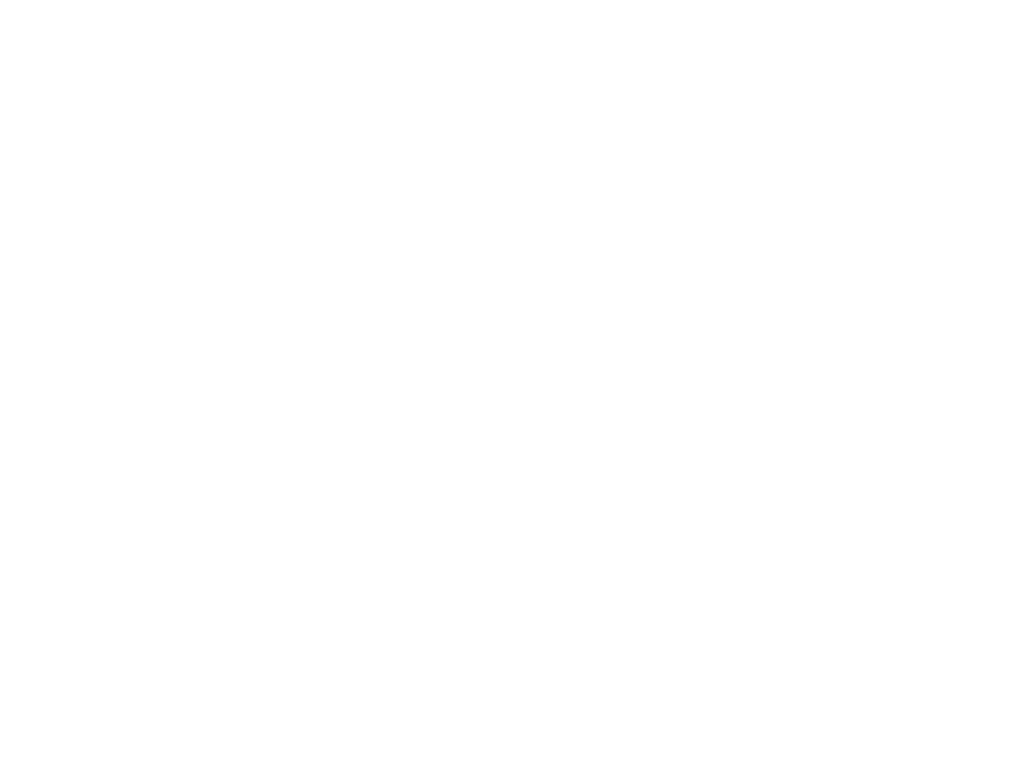

In [28]:
# A good starting camera position - the three values are the camera position,
# the camera focus, and the up vector of the viewport
plotter.camera_position = [(-74, 32, 51), (0, 0, 88), (0, 1, 0)]

plotter.show()